# Steps
1. Reading and Transforming data
2. Clustering
3. Feature Selection 
4. Clustering for reduced data
5. Neural Networks
6. Cluster Data + Neural Networks

In [2]:
from sklearn import preprocessing,metrics,neighbors
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV,train_test_split
from scipy.stats import kurtosis, skew,kurtosistest
import numpy as np
import pylab as pl
import pandas as pd
import time
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GMM
from sklearn import tree, random_projection
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import FastICA, PCA
import random

# Reading and transforming data

Dataset 1

In [3]:
#Reading data
#remove non-predictive variables
data=pd.read_csv('OnlineNewsPopularity.csv')
print("shape",data.shape)

data.drop(['url', ' timedelta'], axis=1, inplace=True)
data.shape

print("\n type of the variables \n", data.dtypes)

shape (39644, 61)

 type of the variables 
  n_tokens_title                   float64
 n_tokens_content                 float64
 n_unique_tokens                  float64
 n_non_stop_words                 float64
 n_non_stop_unique_tokens         float64
 num_hrefs                        float64
 num_self_hrefs                   float64
 num_imgs                         float64
 num_videos                       float64
 average_token_length             float64
 num_keywords                     float64
 data_channel_is_lifestyle        float64
 data_channel_is_entertainment    float64
 data_channel_is_bus              float64
 data_channel_is_socmed           float64
 data_channel_is_tech             float64
 data_channel_is_world            float64
 kw_min_min                       float64
 kw_max_min                       float64
 kw_avg_min                       float64
 kw_min_max                       float64
 kw_max_max                       float64
 kw_avg_max                     

In [4]:
#identifying categorical and numerical variables
#Shares variables will be the numerical variable
categorical_var=[' data_channel_is_lifestyle',' data_channel_is_entertainment',' data_channel_is_bus',
             ' data_channel_is_socmed',' data_channel_is_tech',' data_channel_is_world',
             ' weekday_is_monday',' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',
             ' weekday_is_friday',' weekday_is_saturday',' weekday_is_sunday',' is_weekend']

data_vars=data.columns.values.tolist()
numerical_var=[i for i in data_vars if i not in categorical_var]
numerical_var=numerical_var[0:len(numerical_var)-1]

In [5]:
#normalizing the numerical variables
data_numerical=data[numerical_var]
scaler = preprocessing.MinMaxScaler()#StandardScaler()
scaler.fit(data_numerical)  
data_numerical_scaled = pd.DataFrame(scaler.transform(data_numerical))
data_numerical_scaled.columns=data_numerical.columns

data_catergorical = data[categorical_var]
data_catergorical=data_catergorical.astype(object)


data2 = pd.concat([data_numerical_scaled,data_catergorical,data[' shares']], axis=1)
data2.columns=data.columns

mean :  3395.3801836343455
median: 1400.0
var  :  135182573.71299252
skew :  33.9625997792866
kurt :  1832.4413727401281


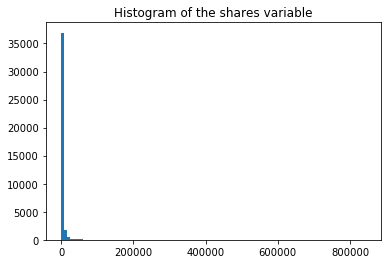

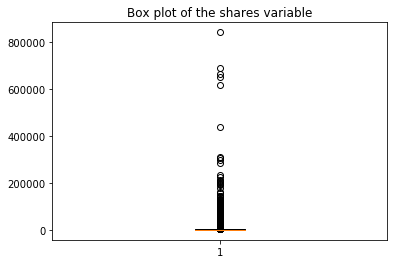

In [6]:
#checking for skewness and kurtosis of the outcome variable (shares)
print("mean : ", np.mean(data[' shares']))
print("median:", np.median(data[' shares']))
print("var  : ", np.var(data[' shares']))
print("skew : ",skew(data[' shares']))
print("kurt : ",kurtosis(data[' shares']))

pl.hist(data[' shares'],bins=100)
pl.title('Histogram of the shares variable')
pl.show()

pl.boxplot(data[' shares'])
pl.title('Box plot of the shares variable')
pl.show()

In [7]:
data3=pd.concat([data_numerical_scaled,data_catergorical,data[' shares']], axis=1)

#Considering if the number of shares above 1400 as high (denoted by 1) and the rest as low (denoted by 0)
#since the shares is skewed, considering a mid point (median) instead of mean
data3[' shares2']=np.where(data3[' shares']>1400, 1, 0)
Y_lo=data3[' shares2']
Y_lo=Y_lo.astype(object)
X_lo=data3.drop([' shares2',' shares'], axis=1)
print("split of number of records classified as high shares (1) vs low shares(0)\n",Y_lo.value_counts())

split of number of records classified as high shares (1) vs low shares(0)
 0    20082
1    19562
Name:  shares2, dtype: int64


In [8]:
#split the data into test and train
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_lo, Y_lo, test_size=0.3, random_state=42)
Y_train_1=list(Y_train_1)
Y_test_1=list(Y_test_1)

Dataset 2

In [9]:
#reading data
bank=pd.read_csv('bankdata.csv', delimiter=';')
print("Total number of records:",len(bank),"\n")
#number of records: 
print("Variable and their data type")
bank.dtypes

Total number of records: 41188 

Variable and their data type


age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

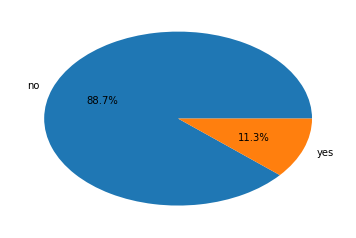

In [10]:
#proportion of clients subscribed for a CD
data=bank.groupby('y')['y'].count()/len(bank)*100
pl.pie(data,autopct='%1.1f%%', labels=[data.index[0],data.index[1]])
pl.show()
# % of clients subsribed for CD is 11.3%

In [11]:
#missing values
data.isnull().sum()
#no missing values 

0

In [12]:
bank["y"]=np.where(bank["y"] == "yes", 1, 0)
bank["y"].value_counts()
bank_y=bank["y"]

In [13]:
#one hot encoding for categorical variables
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']

data_vars=bank.columns.values.tolist()
numerical_var=[i for i in data_vars if i not in cat_vars]

bank_cat=bank[cat_vars]
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(bank[var], prefix=var)
    data1=bank_cat.join(cat_list)
    bank_cat=data1

cat_vars=['previous','duration','job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y_0','y_1','y']
data_vars=bank_cat.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
bank_cat=bank_cat[to_keep]

#bank_cat.dtypes

In [14]:
#normalizing the numerical variables

bank[numerical_var]
data_numerical=bank[numerical_var]
scaler = preprocessing.MinMaxScaler() #StandardScaler()
scaler.fit(data_numerical)  
data_numerical_scaled = pd.DataFrame(scaler.transform(data_numerical))
data_numerical_scaled.columns=data_numerical.columns

bank2 = pd.concat([data_numerical_scaled,bank_cat,bank_y], axis=1)
#bank2.dtypes

In [15]:
bank2_Y=bank2['y']
bank2_X=bank2.drop(['y'], axis=1)
print("split of number of records classified as high shares (1) vs low shares(0)\n",bank2_Y.value_counts())

split of number of records classified as high shares (1) vs low shares(0)
 0    36548
1     4640
Name: y, dtype: int64


In [16]:
#split the data into test and train
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(bank2_X, bank2_Y, test_size=0.3, random_state=42)
Y_train_2=list(Y_train_2)
Y_test_2=list(Y_test_2)

In [17]:
X_1=X_lo
Y_1=Y_lo
X_2=bank2_X
Y_2=bank2_Y

# Clustering

In [110]:
# Kmeans Function
def kmeans_fun(Train,min,max):
    sse={}
    ss={}
    for k in range(min, max):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(Train)
        sse[k] = kmeans.inertia_ 
        ss[k] = silhouette_score(Train, kmeans.labels_, sample_size=20000, random_state=10)
        #ss[k] = silhouette_score(Train, kmeans.labels_, random_state=10)
        
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.title("Clusters vs SSE")
    plt.show()
    
    plt.figure()
    plt.plot(list(ss.keys()), list(ss.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("average silhouette_score")
    plt.title("Clusters vs average silhouette_score")
    plt.show()
    return None

In [138]:
def plot_clusters(x1_kmeans,Y_1,split):
    
    plt.pie(np.unique(x1_kmeans,return_counts=True)[1], labels=np.unique(x1_kmeans,return_counts=True)[0], 
        autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('distribution of data in different clausters')
    plt.axis('equal')
    plt.show()

    #ct_1=pd.DataFrame(pd.crosstab(x1_kmeans,Y_1)*100)
    #ct_1=ct_1.reset_index()
    #ct_1.columns=['Cluster','0','1']
    #width = 0.35  
    #p1 = plt.bar(ct_1['Cluster'], ct_1['0'], width=width, label='0')
    #p2 = plt.bar(ct_1['Cluster']+width, ct_1['1'],width=width, label='1')
    #plt.xlabel("Clusters")
    #plt.ylabel("Count")
    #plt.legend(loc='best')
    #plt.title('Count of different categories across clusters')
    #plt.show()
    
    ct_1=pd.DataFrame(pd.crosstab(x1_kmeans,Y_1,normalize='index')*100)
    ct_1=ct_1.reset_index()
    ct_1.columns=['Cluster','0','1']
    p1 = plt.bar(ct_1['Cluster'], ct_1['0'], label='0')
    p2 = plt.bar(ct_1['Cluster'], ct_1['1'], bottom=ct_1['0'],label='1')
    plt.axhline(y=split, color='r', linestyle='-')
    plt.xlabel("Clusters")
    plt.ylabel("Count")
    plt.legend(loc='best')
    plt.title('Percentage count of different categories across clusters')
    plt.show()
    
    return None

First data set

Kmeans

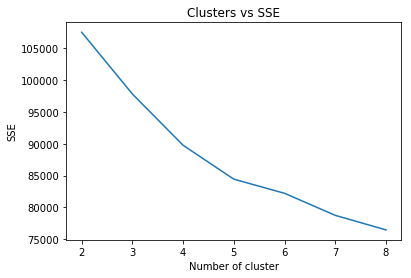

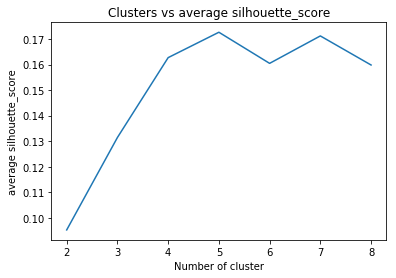

In [21]:
kmeans_fun(X_1,2,9)

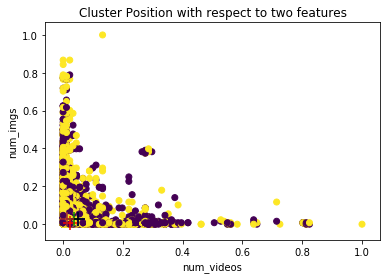

In [19]:
x=X_1[' num_videos'] #8
y=X_1[' num_imgs'] #7

X_1.columns

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, c=Y_1)
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_1)
centers = kmeans.cluster_centers_
ax.scatter(centers[0,[7]],centers[0,[8]],c='red',marker='+',s=200)
ax.scatter(centers[1,[7]],centers[1,[8]],c='blue',marker='+',s=200)
ax.scatter(centers[2,[7]],centers[1,[8]],c='Green',marker='+',s=200)
ax.scatter(centers[3,[7]],centers[1,[8]],c='black',marker='+',s=200)
ax.scatter(centers[4,[7]],centers[1,[8]],c='brown',marker='+',s=200)
ax.set_xlabel('num_videos')
ax.set_ylabel('num_imgs')
ax.set_title('Cluster Position with respect to two features')
plt.show()

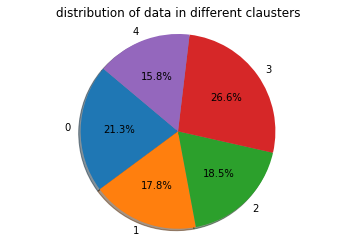

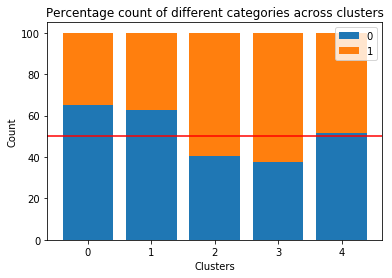

In [139]:
x1_kmeans = KMeans(n_clusters=5, random_state=0).fit_predict(X_1)
plot_clusters(x1_kmeans,Y_1,50)

Expectation Maximization

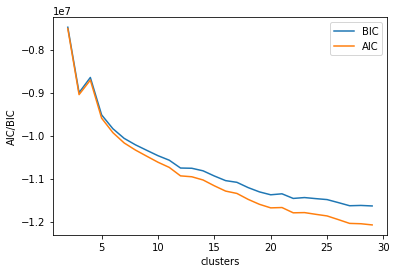

In [59]:
n_components = np.arange(2, 30)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_1)
          for n in n_components]

plt.plot(n_components, [m.bic(X_1) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_1) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('clusters')
plt.ylabel('AIC/BIC')
plt.show()

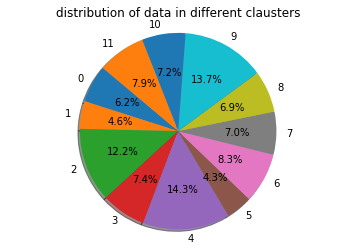

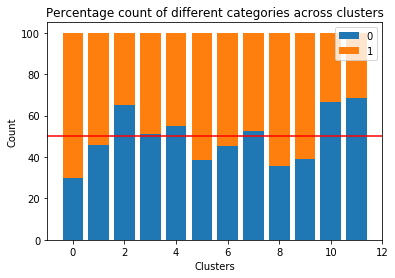

In [140]:
gmm = GaussianMixture(12, covariance_type='full', random_state=0).fit(X_1)
x1_kmeans = gmm.predict(X_1)
plot_clusters(x1_kmeans,Y_1,50)

second dataset

Kmeans

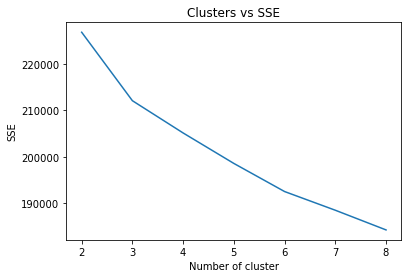

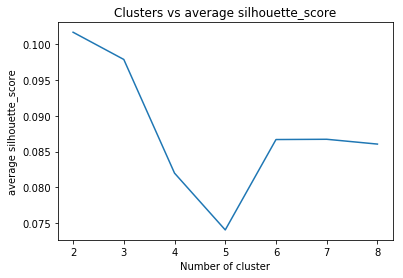

In [102]:
kmeans_fun(X_2,2,9)

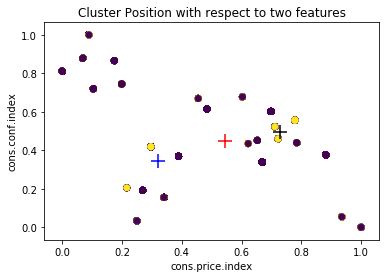

In [114]:
x=X_2['cons.price.idx']
y=X_2['cons.conf.idx'] 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, c=Y_2)
kmeans = KMeans(n_clusters=3, random_state=0).fit(X_2)
centers = kmeans.cluster_centers_
ax.scatter(centers[0,[6]],centers[0,[7]],c='red',marker='+',s=200)
ax.scatter(centers[1,[6]],centers[1,[7]],c='blue',marker='+',s=200)
ax.scatter(centers[2,[6]],centers[2,[7]],c='black',marker='+',s=200)
ax.set_xlabel('cons.price.index')
ax.set_ylabel('cons.conf.index')
ax.set_title('Cluster Position with respect to two features')
plt.show()

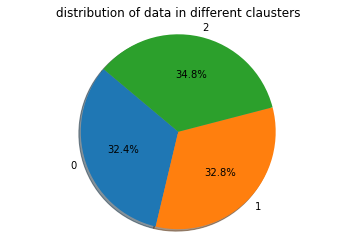

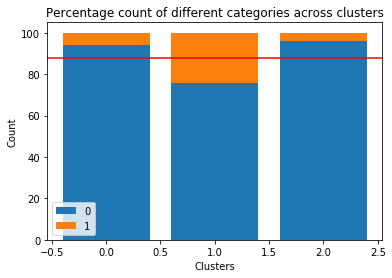

In [141]:
x2_kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(X_2)
plot_clusters(x2_kmeans,Y_2,88)

Expectation Maximization

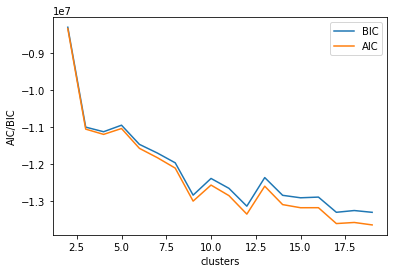

In [60]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_2)
          for n in n_components]

plt.plot(n_components, [m.bic(X_2) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_2) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('clusters')
plt.ylabel('AIC/BIC')
plt.show()

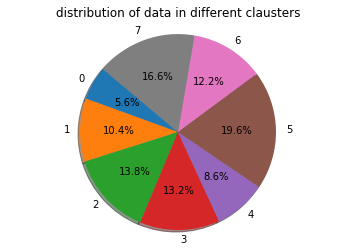

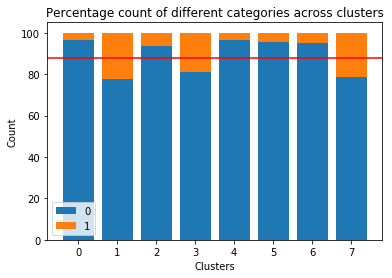

In [194]:
gmm = GaussianMixture(8, covariance_type='full', random_state=0).fit(X_2)
x2_kmeans = gmm.predict(X_2)
plot_clusters(x2_kmeans,Y_2,88)

# Feature selection

first dataset

Number of features before transformation: (39644, 58)
Number of features after transformation: (39644, 26)
columns retained: Index([' n_tokens_content', ' n_unique_tokens', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' average_token_length', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg',
       ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess', ' LDA_00',
       ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' avg_positive_polarity',
       ' avg_negative_polarity'],
      dtype='object')


C:\Users\saivi\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


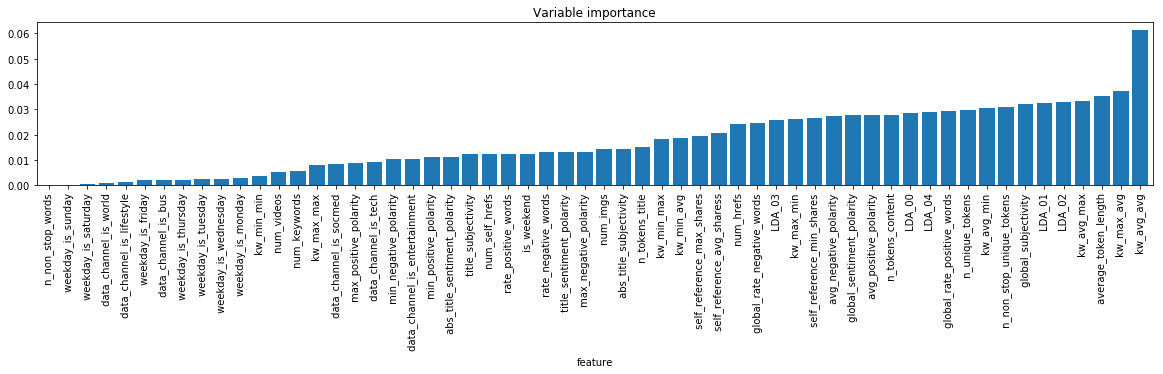

In [18]:
Y_1_copy=Y_1.astype('int')
dt = tree.DecisionTreeClassifier(random_state=0,criterion="entropy")
dt.fit(X_1,Y_1_copy)
print("Number of features before transformation:",X_1.shape)
dt.feature_importances_  
model = SelectFromModel(dt, prefit=True)
X_1_dt = model.transform(X_1)
print("Number of features after transformation:",X_1_dt.shape )
print("columns retained:",X_1.columns[model.get_support()])
dt_1_features=pd.concat([pd.DataFrame(X_1.columns),pd.DataFrame(dt.feature_importances_)],axis=1)
dt_1_features.columns=['feature','imp']
dt_1_features.sort_values(by=['imp'],inplace=True)
dt_1_features.set_index('feature',inplace=True)
plt.figure(figsize=(20, 3))
dt_1_features['imp'].plot.bar(width=0.8)
plt.title('Variable importance')
plt.show()

second dataset

Number of features before transformation: (41188, 63)
Number of features after transformation: (41188, 6)
columns retained: Index(['age', 'duration', 'campaign', 'cons.conf.idx', 'euribor3m',
       'nr.employed'],
      dtype='object')


C:\Users\saivi\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


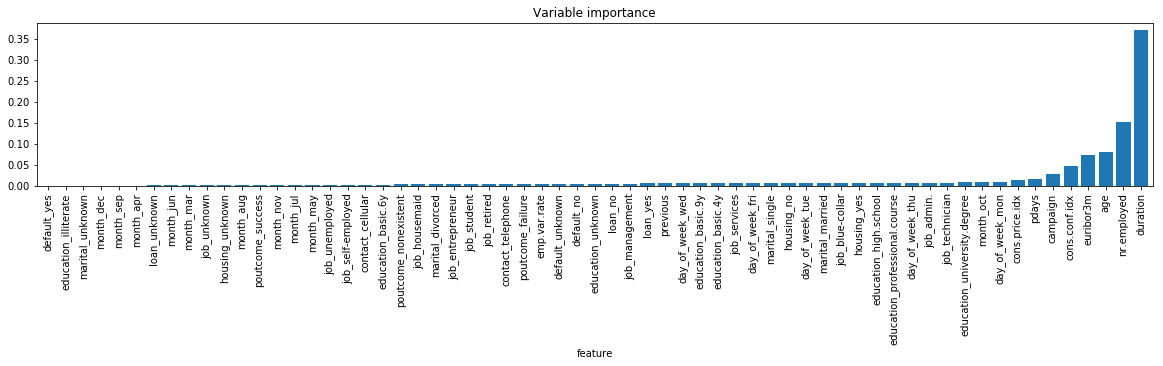

In [19]:
Y_2_copy=Y_2.astype('int')
dt = tree.DecisionTreeClassifier(random_state=0,criterion="entropy")
dt.fit(X_2,Y_2_copy)
print("Number of features before transformation:",X_2.shape)
dt.feature_importances_  
model = SelectFromModel(dt, prefit=True)
X_2_dt = model.transform(X_2)
print("Number of features after transformation:",X_2_dt.shape )
print("columns retained:",X_2.columns[model.get_support()])
dt_1_features=pd.concat([pd.DataFrame(X_2.columns),pd.DataFrame(dt.feature_importances_)],axis=1)
dt_1_features.columns=['feature','imp']
dt_1_features.sort_values(by=['imp'],inplace=True)
dt_1_features.set_index('feature',inplace=True)
plt.figure(figsize=(20, 3))
dt_1_features['imp'].plot.bar(width=0.8)
plt.title('Variable importance')
plt.show()

# PCA

first dataset

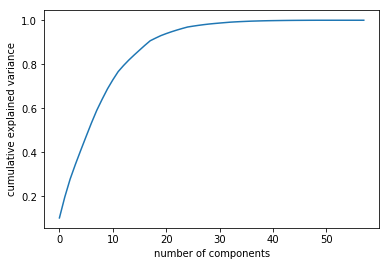

Number of features with no reduction: (39644, 58)
Number of features after PCA: (39644, 18)

PC 1 is loaded on high on feature:  data_channel_is_tech
PC 2 is loaded on high on feature:  data_channel_is_bus
PC 3 is loaded on high on feature:  abs_title_subjectivity
PC 4 is loaded on high on feature:  is_weekend
PC 5 is loaded on high on feature:  weekday_is_wednesday
PC 6 is loaded on high on feature:  weekday_is_thursday


In [20]:
pca = PCA().fit(X_1)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
pca = PCA(0.90).fit(X_1)
X_1_pca=pca.transform(X_1)
print("Number of features with no reduction:", X_1.shape)

print("Number of features after PCA:", X_1_pca.shape)
print("")
pca_loadings=pca.components_.T * np.sqrt(pca.explained_variance_)
for i in range(1,7):
    print("PC",i,"is loaded on high on feature:",X_1.columns[max(abs(pca_loadings[:,i]))==abs(pca_loadings[:,i])][0])

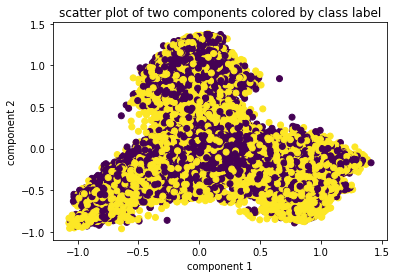

In [46]:
x=X_1_pca[:,1]
y=X_1_pca[:,2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, c=Y_1)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
plt.title('scatter plot of two components colored by class label')
plt.show()

second dataset

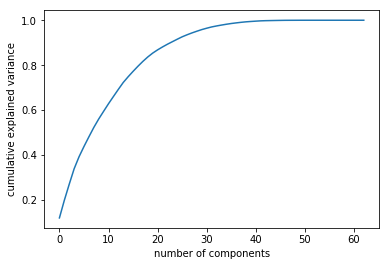

Number of features with no reduction: (41188, 63)
Number of features after PCA: (41188, 24)

PC 1 is loaded on high on feature: housing_yes
PC 2 is loaded on high on feature: marital_married
PC 3 is loaded on high on feature: month_may
PC 4 is loaded on high on feature: marital_married
PC 5 is loaded on high on feature: education_university.degree
PC 6 is loaded on high on feature: loan_no


In [21]:
pca = PCA().fit(X_2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()
pca = PCA(0.9).fit(X_2)
X_2_pca=pca.transform(X_2)
print("Number of features with no reduction:", X_2.shape)
print("Number of features after PCA:", X_2_pca.shape)
print("")
pca_loadings=pca.components_.T * np.sqrt(pca.explained_variance_)
for i in range(1,7):
    print("PC",i,"is loaded on high on feature:",X_2.columns[max(abs(pca_loadings[:,i]))==abs(pca_loadings[:,i])][0])

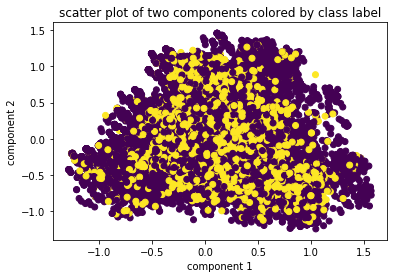

In [49]:
x=X_2_pca[:,8]
y=X_2_pca[:,7]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y, c=Y_2)
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
plt.title('scatter plot of two components colored by class label')
plt.show()

# ICA

First dataset

C:\Users\saivi\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


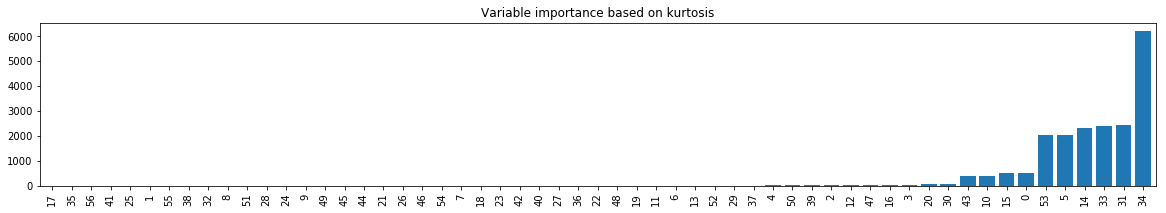

Number of features after reduction (39644, 4)


In [22]:
ica = FastICA(random_state=0)
X_1_ica = ica.fit_transform(X_1)  # Reconstruct signals
kk_1=[]
index=[]
for i in range(1, X_1_ica.shape[1]):
    kk_1.append(abs(kurtosis(X_1_ica[:,i], fisher=True)))
    index.append(i)
kk_1_pd=pd.DataFrame(kk_1,index)
kk_1_pd.reset_index(inplace=True)
kk_1_pd.columns=['index','kurtosis']
kk_1_pd=kk_1_pd.sort_values(['kurtosis'],ascending=[1])
plt.figure(figsize=(20, 3))
kk_1_pd['kurtosis'].plot.bar(width=0.8)
plt.title('Variable importance based on kurtosis')
plt.show()
X_1_ica=X_1_ica[:,kk_1_pd[kk_1_pd['kurtosis']<=1]['index']]
print("Number of features after reduction",X_1_ica.shape)

second datasets

C:\Users\saivi\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


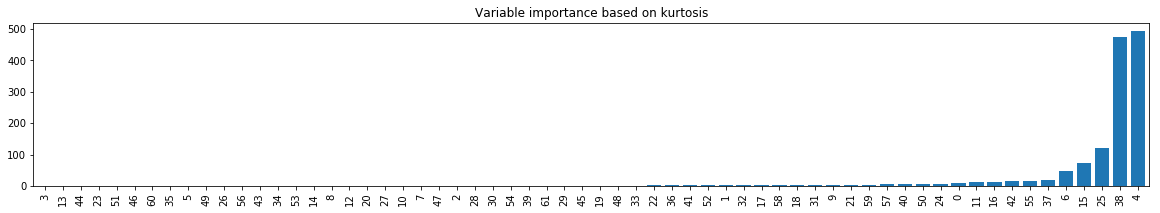

Number of features after reduction (41188, 24)


In [23]:
ica = FastICA(random_state=0)
X_2_ica = ica.fit_transform(X_2)  # Reconstruct signals
kk_2=[]
index=[]
for i in range(1, X_2_ica.shape[1]):
    kk_2.append(abs(kurtosis(X_2_ica[:,i], fisher=True)))
    index.append(i)
kk_2_pd=pd.DataFrame(kk_2,index)
kk_2_pd.reset_index(inplace=True)
kk_2_pd.columns=['index','kurtosis']
kk_2_pd=kk_2_pd.sort_values(['kurtosis'],ascending=[1])
plt.figure(figsize=(20, 3))
kk_2_pd['kurtosis'].plot.bar(width=0.8)
plt.title('Variable importance based on kurtosis')
plt.show()
X_2_ica=X_2_ica[:,kk_2_pd[kk_2_pd['kurtosis']<=1]['index']]
print("Number of features after reduction",X_2_ica.shape)

# Random Projections

First Dataset

In [24]:
def custom1(data, orig_dimension, new_dimension):
    minusOne = 0.1
    one = 0.9
    rows = len(data)
    m = np.empty((orig_dimension, new_dimension))
    # build random matrix
    for i in range(len(m)):
        for j in range(len(m[i])):
            rand = random.random()
            if rand < minusOne:
                m[i][j] = -1
            elif rand >= one:
                m[i][j] = 1
            else:
                m[i][j] = 0
    reduced = np.mat(data) * m
    #reduced=""
    return reduced,m

In [25]:
#first
X_1_ra,m=custom1(X_1, X_1.shape[1], int(X_1.shape[1]/2))

print("Number of components after reduction:",X_1_ra.shape)

Number of components after reduction: (39644, 29)


In [26]:
#second
X_2_ra,m=custom1(X_2, X_2.shape[1], int(X_2.shape[1]/2))

print("Number of components after reduction:",X_2_ra.shape)

Number of components after reduction: (41188, 31)


In [27]:
X_1_dt=pd.DataFrame(X_1_dt)
X_1_pca=pd.DataFrame(X_1_pca)
X_1_ica=pd.DataFrame(X_1_ica)
X_1_ra=pd.DataFrame(X_1_ra)
X_2_dt=pd.DataFrame(X_2_dt)
X_2_pca=pd.DataFrame(X_2_pca)
X_2_ica=pd.DataFrame(X_2_ica)
X_2_ra=pd.DataFrame(X_2_ra)

# Clustering for reduced data

Feature selection - Decision Trees

first dataset

Kmeans

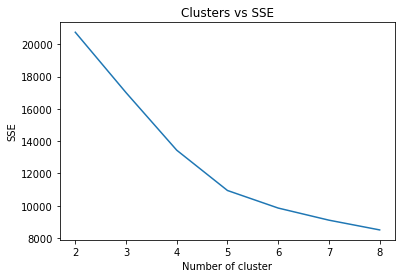

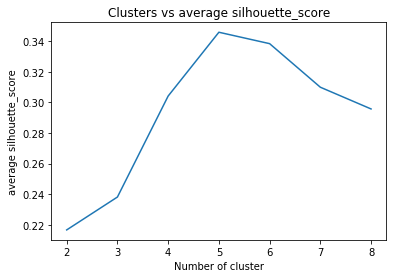

In [112]:
kmeans_fun(X_1_dt,2,9)

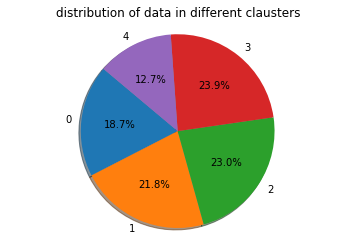

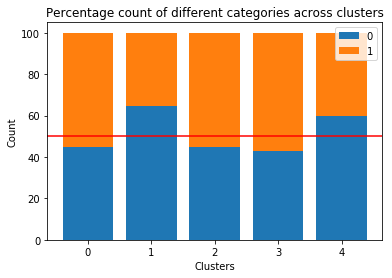

In [143]:
x1_kmeans = KMeans(n_clusters=5, random_state=0).fit_predict(X_1_dt)
plot_clusters(x1_kmeans,Y_1,50)

Expectation Maximization

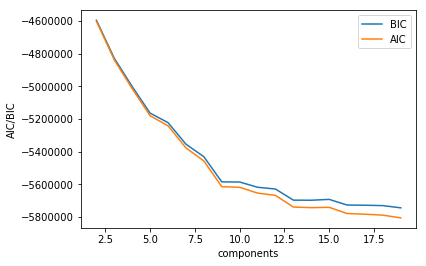

In [114]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_1_dt)
          for n in n_components]

plt.plot(n_components, [m.bic(X_1_dt) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_1_dt) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('AIC/BIC')
plt.show()

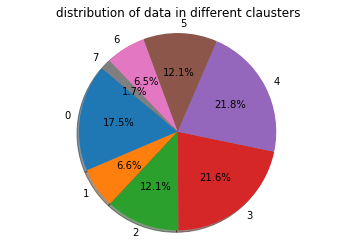

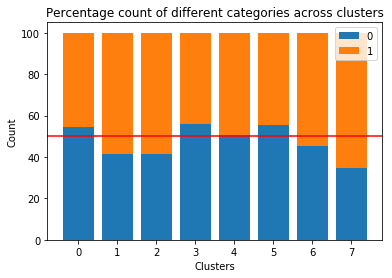

In [144]:
gmm = GaussianMixture(8, covariance_type='full', random_state=0).fit(X_1_dt)
x1_kmeans = gmm.predict(X_1_dt)
plot_clusters(x1_kmeans,Y_1,50)

second dataset

Kmeans

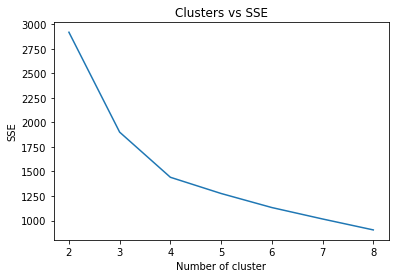

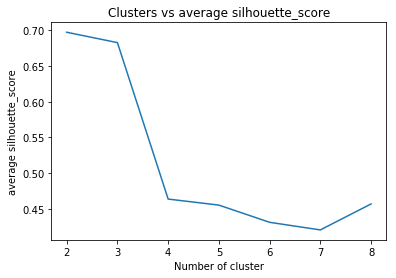

In [116]:
kmeans_fun(X_2_dt,2,9)

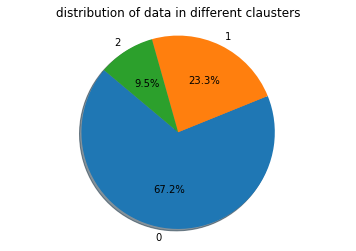

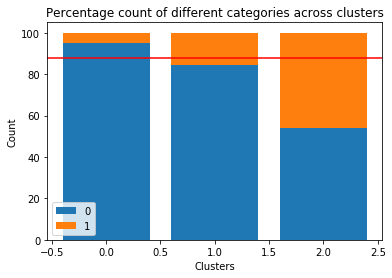

In [145]:
x2_kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(X_2_dt)
plot_clusters(x2_kmeans,Y_2,88)

Expectation Maximization

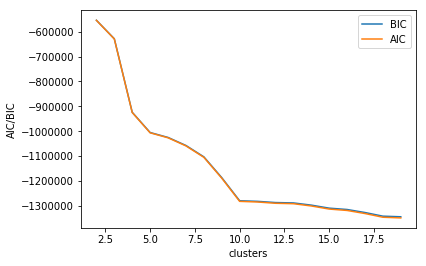

In [63]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_2_dt)
          for n in n_components]

plt.plot(n_components, [m.bic(X_2_dt) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_2_dt) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('clusters')
plt.ylabel('AIC/BIC')
plt.show()

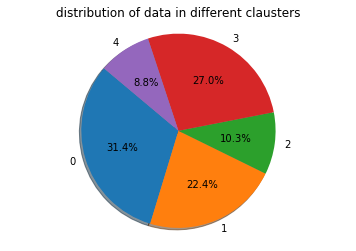

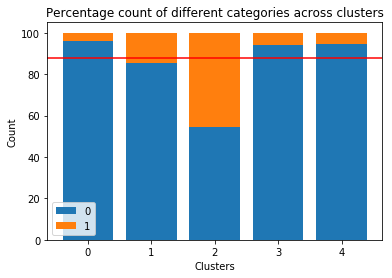

In [147]:
gmm = GaussianMixture(5, covariance_type='full', random_state=0).fit(X_2_dt)
x2_kmeans = gmm.predict(X_2_dt)
plot_clusters(x2_kmeans,Y_2,88)

Feature selection - PCA

first dataset

Kmeans

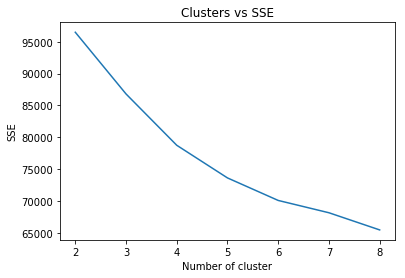

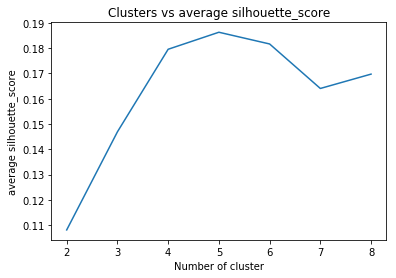

In [148]:
kmeans_fun(X_1_pca,2,9)

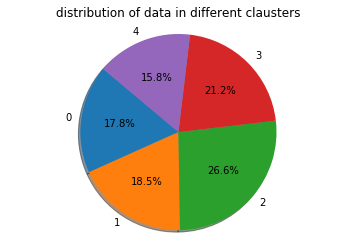

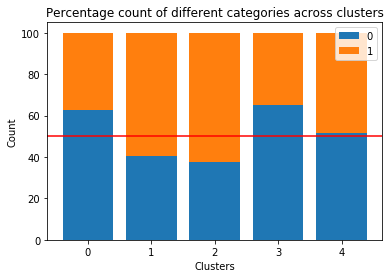

In [150]:
x1_kmeans = KMeans(n_clusters=5, random_state=0).fit_predict(X_1_pca)
plot_clusters(x1_kmeans,Y_1,50)

Expectation Maximization

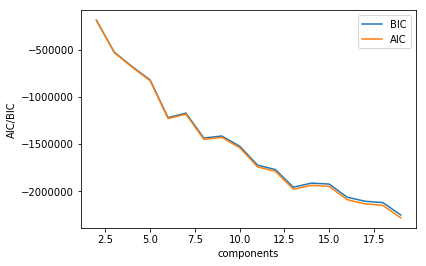

In [151]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_1_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_1_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_1_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('AIC/BIC')
plt.show()

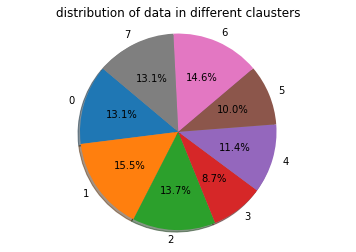

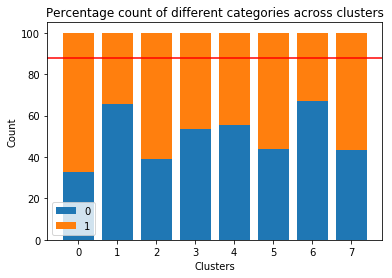

In [152]:
gmm = GaussianMixture(8, covariance_type='full', random_state=0).fit(X_1_pca)
x1_kmeans = gmm.predict(X_1_pca)
plot_clusters(x1_kmeans,Y_1,88)

second dataset

Kmeans

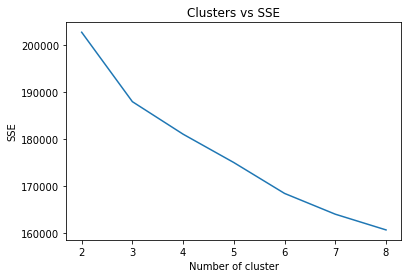

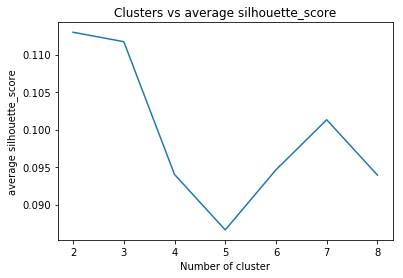

In [153]:
kmeans_fun(X_2_pca,2,9)

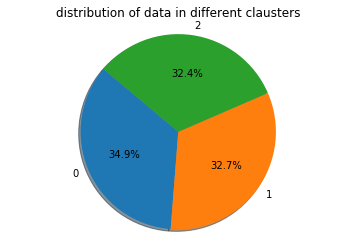

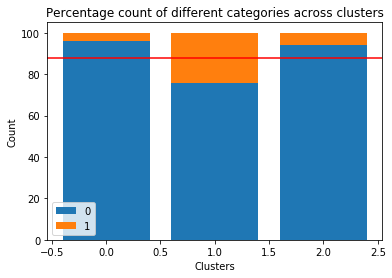

In [154]:
x2_kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(X_2_pca)
plot_clusters(x2_kmeans,Y_2,88)

Expectation Maximization

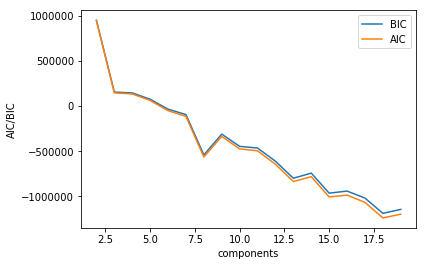

In [155]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_2_pca)
          for n in n_components]

plt.plot(n_components, [m.bic(X_2_pca) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_2_pca) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('AIC/BIC')
plt.show()

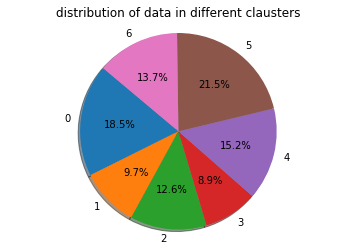

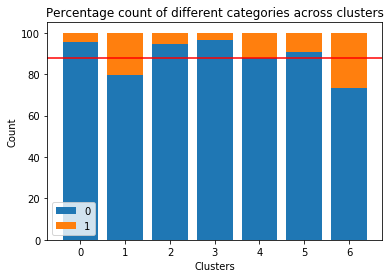

In [156]:
gmm = GaussianMixture(7, covariance_type='full', random_state=0).fit(X_2_pca)
x2_kmeans = gmm.predict(X_2_pca)
plot_clusters(x2_kmeans,Y_2,88)

Feature selection - ICA

first dataset

Kmeans

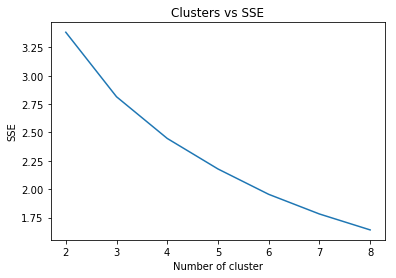

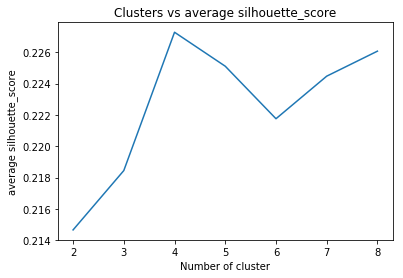

In [223]:
kmeans_fun(X_1_ica,2,9)

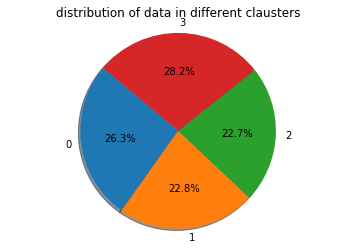

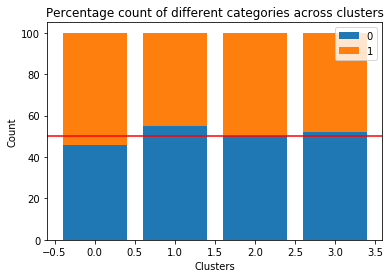

In [224]:
x1_kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(X_1_ica)
plot_clusters(x1_kmeans,Y_1,50)

Expectation Maximization

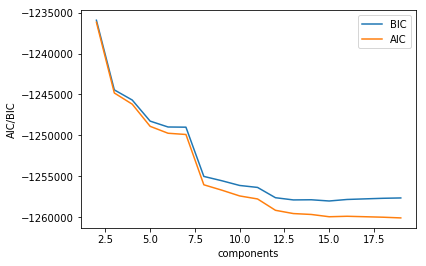

In [225]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_1_ica)
          for n in n_components]

plt.plot(n_components, [m.bic(X_1_ica) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_1_ica) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('AIC/BIC')
plt.show()

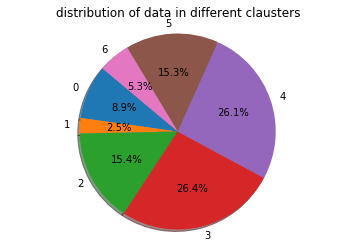

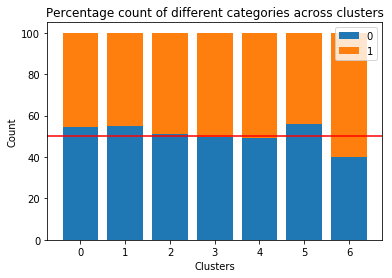

In [226]:
gmm = GaussianMixture(7, covariance_type='full', random_state=0).fit(X_1_ica)
x1_kmeans = gmm.predict(X_1_ica)
plot_clusters(x1_kmeans,Y_1,50)

second dataset

Kmeans

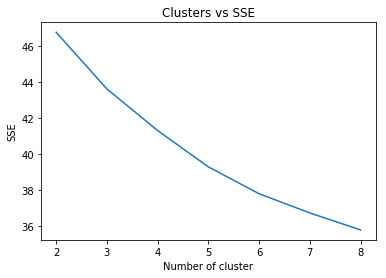

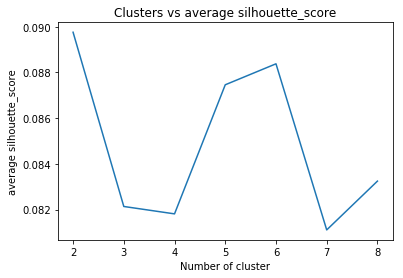

In [229]:
kmeans_fun(X_2_ica,2,9)

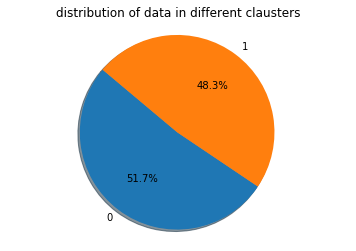

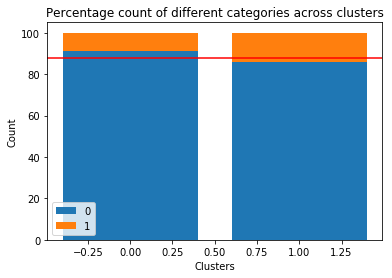

In [230]:
x2_kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X_2_ica)
plot_clusters(x2_kmeans,Y_2,88)

Expectation Maximization

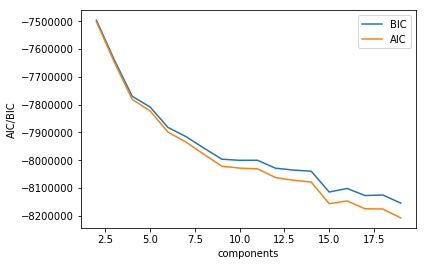

In [231]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_2_ica)
          for n in n_components]

plt.plot(n_components, [m.bic(X_2_ica) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_2_ica) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('AIC/BIC')
plt.show()

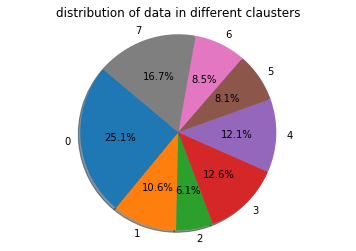

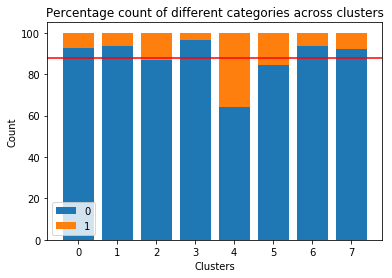

In [233]:
gmm = GaussianMixture(8, covariance_type='full', random_state=0).fit(X_2_ica)
x2_kmeans = gmm.predict(X_2_ica)
plot_clusters(x2_kmeans,Y_2,88)

Feature selection - RA

first dataset

Kmeans

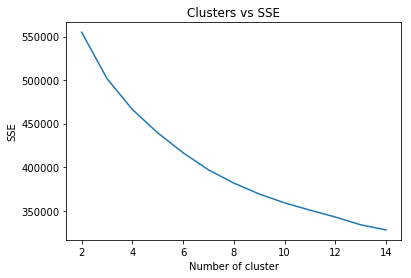

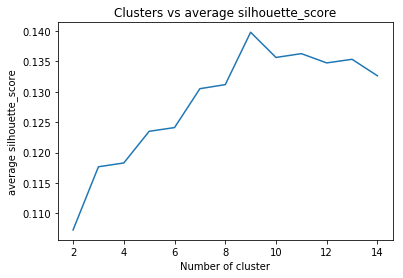

In [178]:
kmeans_fun(X_1_ra,2,15)

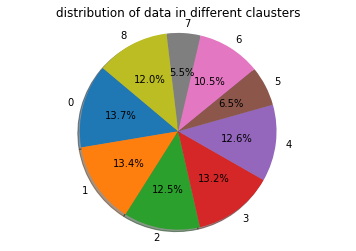

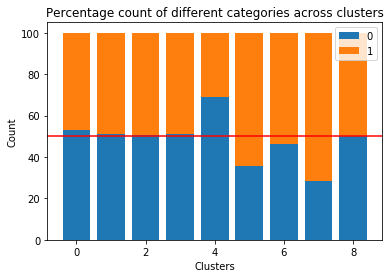

In [180]:
x1_kmeans = KMeans(n_clusters=9, random_state=0).fit_predict(X_1_ra)
plot_clusters(x1_kmeans,Y_1,50)

Expectation Maximization

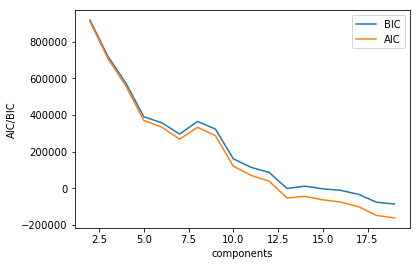

In [181]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_1_ra)
          for n in n_components]

plt.plot(n_components, [m.bic(X_1_ra) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_1_ra) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('AIC/BIC')
plt.show()

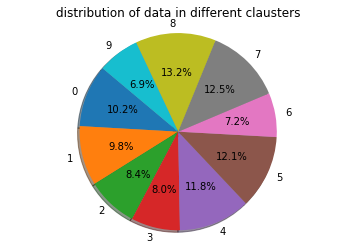

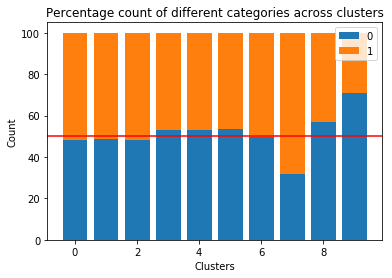

In [182]:
gmm = GaussianMixture(10, covariance_type='full', random_state=0).fit(X_1_ra)
x1_kmeans = gmm.predict(X_1_ra)
plot_clusters(x1_kmeans,Y_1,50)

second dataset

Kmeans

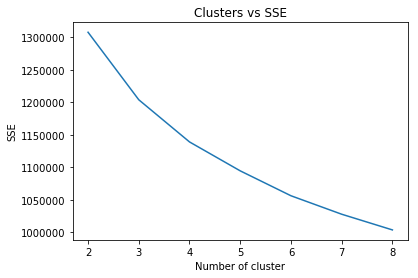

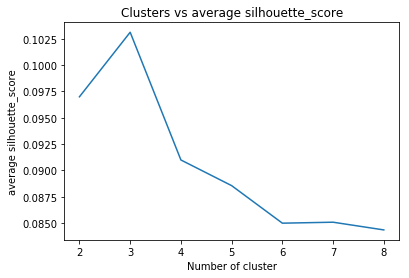

In [189]:
kmeans_fun(X_2_ra,2,9)

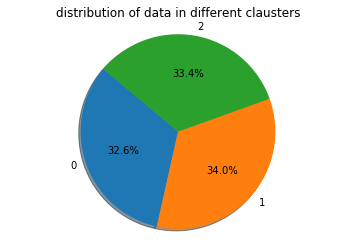

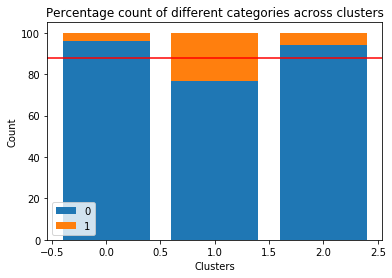

In [190]:
x2_kmeans = KMeans(n_clusters=3, random_state=0).fit_predict(X_2_ra)
plot_clusters(x2_kmeans,Y_2,88)

Expectation Maximization

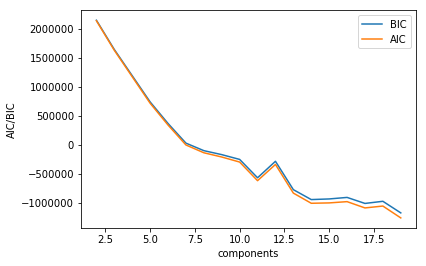

In [191]:
n_components = np.arange(2, 20)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_2_ra)
          for n in n_components]

plt.plot(n_components, [m.bic(X_2_ra) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_2_ra) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('components')
plt.ylabel('AIC/BIC')
plt.show()

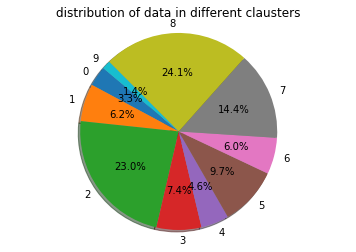

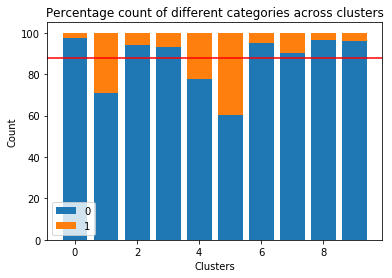

In [193]:
gmm = GaussianMixture(10, covariance_type='full', random_state=0).fit(X_2_ra)
x2_kmeans = gmm.predict(X_2_ra)
plot_clusters(x2_kmeans,Y_2,88)

# Nueral Networks

In [28]:
#data
def split(X_1_dt, Y_1):
    X_train_1_dt, X_test_1_dt, Y_train_1_dt, Y_test_1_dt = train_test_split(X_1_dt, Y_1, test_size=0.3, random_state=42)
    Y_train_1_dt=list(Y_train_1_dt)
    Y_test_1_dt=list(Y_test_1_dt)
    return X_train_1_dt, X_test_1_dt, Y_train_1_dt, Y_test_1_dt

X_train_1_dt, X_test_1_dt, Y_train_1_dt, Y_test_1_dt = split(X_1_dt, Y_1)
X_train_1_pca, X_test_1_pca, Y_train_1_pca, Y_test_1_pca = split(X_1_pca, Y_1)
X_train_1_ica, X_test_1_ica, Y_train_1_ica, Y_test_1_ica = split(X_1_ica, Y_1)
X_train_1_ra, X_test_1_ra, Y_train_1_ra, Y_test_1_ra = split(X_1_ra, Y_1)

X_train_2_dt, X_test_2_dt, Y_train_2_dt, Y_test_2_dt = split(X_2_dt, Y_2)
X_train_2_pca, X_test_2_pca, Y_train_2_pca, Y_test_2_pca = split(X_2_pca, Y_2)
X_train_2_ica, X_test_2_ica, Y_train_2_ica, Y_test_2_ica = split(X_2_ica, Y_2)
X_train_2_ra, X_test_2_ra, Y_train_2_ra, Y_test_2_ra = split(X_2_ra, Y_2)


In [29]:
#function def
def vary_func1_helper(X_train,Y_train,input_dims,output_dims,parameters,cv):
    def build_classifier(optimizer,first_hidden_units,second_hidden_units,hidden_activation_fun,output_activation_func):
        classifier = Sequential()
        classifier.add(Dense(output_dim = first_hidden_units, init = 'uniform', activation = hidden_activation_fun, input_dim = input_dims))
        # Adding the second hidden layer
        classifier.add(Dense(output_dim = second_hidden_units, init = 'uniform', activation = hidden_activation_fun))
        # Adding the output layer
        classifier.add(Dense(output_dim = output_dims, init = 'uniform', activation = output_activation_func))
        classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
        return classifier

    classifier = KerasClassifier(build_fn = build_classifier)

    grid_search = GridSearchCV(estimator = classifier,
                       param_grid = parameters,
                       scoring = 'accuracy',
                       cv = cv)
    #grid_search = grid_search.fit(X_train, Y_train)
    
    return grid_search

In [30]:
#function def
def vary_func1(X_train,Y_train,X_test,Y_test,input_dims,output_dims,parameters,cv):
        start_time_iter = time.time()
        grid_search=vary_func1_helper(X_train,Y_train,X_train.shape[1],output_dims,parameters,cv)
        grid_search = grid_search.fit(X_train, Y_train)
        cv_acc=np.round(grid_search.cv_results_['mean_test_score'],4)*100
        train_acc=np.round(accuracy_score(grid_search.predict(X_train),Y_train),4)*100
        test_acc=np.round(accuracy_score(grid_search.predict(X_test),Y_test),4)*100
        times=time.time()-start_time_iter 
        return grid_search,times,cv_acc,train_acc,test_acc

first dataset

In [31]:
vary_1_param_1 = {'batch_size': [64],'epochs': [10],'optimizer': ['rmsprop'],'first_hidden_units':[20],'second_hidden_units':[10],'hidden_activation_fun':['relu'],'output_activation_func':['sigmoid']}

In [32]:
#first
vary_grid_1_org,times_1_org,cv_acc_1_org,train_acc_1_org,test_acc_1_org=vary_func1(X_train_1,Y_train_1,X_test_1,Y_test_1,X_train_1.shape[1],1,vary_1_param_1,3)
vary_grid_1_dt,times_1_dt,cv_acc_1_dt,train_acc_1_dt,test_acc_1_dt=vary_func1(X_train_1_dt,Y_train_1_dt,X_test_1_dt,Y_test_1_dt,X_train_1_dt.shape[1],1,vary_1_param_1,3)
vary_grid_1_pca,times_1_pca,cv_acc_1_pca,train_acc_1_pca,test_acc_1_pca=vary_func1(X_train_1_pca,Y_train_1_pca,X_test_1_pca,Y_test_1_pca,X_train_1_pca.shape[1],1,vary_1_param_1,3)
vary_grid_1_ica,times_1_ica,cv_acc_1_ica,train_acc_1_ica,test_acc_1_ica=vary_func1(X_train_1_ica,Y_train_1_ica,X_test_1_ica,Y_test_1_ica,X_train_1_ica.shape[1],1,vary_1_param_1,3)
vary_grid_1_ra,times_1_ra,cv_acc_1_ra,train_acc_1_ra,test_acc_1_ra=vary_func1(X_train_1_ra,Y_train_1_ra,X_test_1_ra,Y_test_1_ra,X_train_1_ra.shape[1],1,vary_1_param_1,3)

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=58, units=20, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=10, kernel_initializer="uniform")`
  import sys
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if __name__ == '__main__':


Epoch 1/10
18500/18500 [==============================] - 1s 57us/step - loss: 0.6772 - acc: 0.5933
Epoch 2/10
18500/18500 [==============================] - 1s 48us/step - loss: 0.6480 - acc: 0.6309
Epoch 3/10
18500/18500 [==============================] - 1s 48us/step - loss: 0.6440 - acc: 0.6314
Epoch 4/10
18500/18500 [==============================] - 1s 60us/step - loss: 0.6423 - acc: 0.6364
Epoch 5/10
18500/18500 [==============================] - 1s 70us/step - loss: 0.6403 - acc: 0.6384
Epoch 6/10
18500/18500 [==============================] - 1s 64us/step - loss: 0.6391 - acc: 0.6382
Epoch 7/10
18500/18500 [==============================] - 1s 64us/step - loss: 0.6382 - acc: 0.6378
Epoch 8/10
18500/18500 [==============================] - 1s 57us/step - loss: 0.6368 - acc: 0.6423
Epoch 9/10
18500/18500 [==============================] - 1s 44us/step - loss: 0.6362 - acc: 0.6418
Epoch 10/10
18500/18500 [==============================] - 1s 47us/step - loss: 0.6350 - acc: 0.6404

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=26, units=20, kernel_initializer="uniform")`
  """


Epoch 1/10
18500/18500 [==============================] - 1s 41us/step - loss: 0.6873 - acc: 0.5679
Epoch 2/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6698 - acc: 0.5913
Epoch 3/10
18500/18500 [==============================] - 1s 28us/step - loss: 0.6657 - acc: 0.5926
Epoch 4/10
18500/18500 [==============================] - 1s 28us/step - loss: 0.6637 - acc: 0.5943
Epoch 5/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6619 - acc: 0.5968
Epoch 6/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6605 - acc: 0.5986
Epoch 7/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6592 - acc: 0.6022
Epoch 8/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6579 - acc: 0.6032
Epoch 9/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6569 - acc: 0.6102
Epoch 10/10
18500/18500 [==============================] - 1s 28us/step - loss: 0.6560 - acc: 0.6080

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=18, units=20, kernel_initializer="uniform")`
  """


Epoch 1/10
18500/18500 [==============================] - 1s 53us/step - loss: 0.6746 - acc: 0.5973
Epoch 2/10
18500/18500 [==============================] - 1s 27us/step - loss: 0.6498 - acc: 0.6285
Epoch 3/10
18500/18500 [==============================] - 1s 29us/step - loss: 0.6483 - acc: 0.6298
Epoch 4/10
18500/18500 [==============================] - 0s 26us/step - loss: 0.6479 - acc: 0.6302
Epoch 5/10
18500/18500 [==============================] - 0s 26us/step - loss: 0.6474 - acc: 0.6285
Epoch 6/10
18500/18500 [==============================] - 1s 29us/step - loss: 0.6470 - acc: 0.6305
Epoch 7/10
18500/18500 [==============================] - 1s 29us/step - loss: 0.6465 - acc: 0.6321
Epoch 8/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6460 - acc: 0.6330
Epoch 9/10
18500/18500 [==============================] - 0s 23us/step - loss: 0.6455 - acc: 0.6336
Epoch 10/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6446 - acc: 0.6342

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=4, units=20, kernel_initializer="uniform")`
  """


Epoch 1/10
18500/18500 [==============================] - 1s 59us/step - loss: 0.6932 - acc: 0.5018
Epoch 2/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6932 - acc: 0.5010
Epoch 3/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6932 - acc: 0.5018
Epoch 4/10
18500/18500 [==============================] - 1s 32us/step - loss: 0.6932 - acc: 0.5026
Epoch 5/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6931 - acc: 0.5026
Epoch 6/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6931 - acc: 0.5024
Epoch 7/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6930 - acc: 0.5076
Epoch 8/10
18500/18500 [==============================] - 1s 29us/step - loss: 0.6929 - acc: 0.5140
Epoch 9/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6926 - acc: 0.5205
Epoch 10/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6923 - acc: 0.5326

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=29, units=20, kernel_initializer="uniform")`
  """


Epoch 1/10
18500/18500 [==============================] - 1s 75us/step - loss: 0.6806 - acc: 0.5806
Epoch 2/10
18500/18500 [==============================] - 1s 37us/step - loss: 0.6666 - acc: 0.6126
Epoch 3/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6611 - acc: 0.6141
Epoch 4/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6571 - acc: 0.6169
Epoch 5/10
18500/18500 [==============================] - 1s 27us/step - loss: 0.6543 - acc: 0.6190
Epoch 6/10
18500/18500 [==============================] - 1s 30us/step - loss: 0.6517 - acc: 0.6223
Epoch 7/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6499 - acc: 0.6244
Epoch 8/10
18500/18500 [==============================] - 1s 31us/step - loss: 0.6485 - acc: 0.6250
Epoch 9/10
18500/18500 [==============================] - 1s 33us/step - loss: 0.6466 - acc: 0.6290
Epoch 10/10
18500/18500 [==============================] - 1s 33us/step - loss: 0.6458 - acc: 0.6284

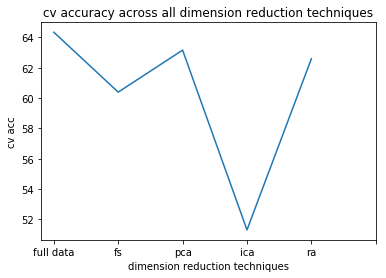

In [33]:
dim = np.array(["full data","fs","pca","ica","ra"])
cv_acc_1 = np.array([cv_acc_1_org,cv_acc_1_dt,cv_acc_1_pca,cv_acc_1_ica,cv_acc_1_ra])
plt.plot(cv_acc_1)
plt.xticks([0,1, 2, 3,4,5], dim)
plt.xlabel('dimension reduction techniques')
plt.ylabel('cv acc')
plt.title('cv accuracy across all dimension reduction techniques')
plt.show()

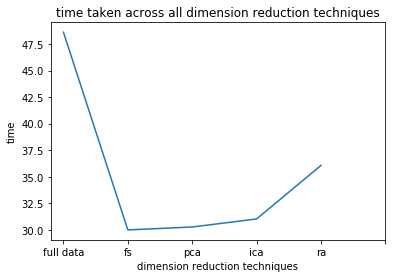

In [34]:
dim = np.array(["full data","fs","pca","ica","ra"])
cv_acc_1 = np.array([times_1_org,times_1_dt,times_1_pca,times_1_ica,times_1_ra])
plt.plot(cv_acc_1)
plt.xticks([0,1, 2, 3,4,5], dim)
plt.xlabel('dimension reduction techniques')
plt.ylabel('time')
plt.title('time taken across all dimension reduction techniques')
plt.show()

second dataset

In [35]:
vary_1_param_2 = vary_1_param = {'batch_size': [32],'epochs': [10],'optimizer': ['adam'],'first_hidden_units':[30],'second_hidden_units':[15],'hidden_activation_fun':['relu'],'output_activation_func':['sigmoid']}

In [36]:
#second
vary_grid_2_org,times_2_org,cv_acc_2_org,train_acc_2_org,test_acc_2_org=vary_func1(X_train_2,Y_train_2,X_test_2,Y_test_2,X_train_2.shape[1],1,vary_1_param_2,3)
vary_grid_2_dt,times_2_dt,cv_acc_2_dt,train_acc_2_dt,test_acc_2_dt=vary_func1(X_train_2_dt,Y_train_2_dt,X_test_2_dt,Y_test_2_dt,X_train_2_dt.shape[1],1,vary_1_param_2,3)
vary_grid_2_pca,times_2_pca,cv_acc_2_pca,train_acc_2_pca,test_acc_2_pca=vary_func1(X_train_2_pca,Y_train_2_pca,X_test_2_pca,Y_test_2_pca,X_train_2_pca.shape[1],1,vary_1_param_2,3)
vary_grid_2_ica,times_2_ica,cv_acc_2_ica,train_acc_2_ica,test_acc_2_ica=vary_func1(X_train_2_ica,Y_train_2_ica,X_test_2_ica,Y_test_2_ica,X_train_2_ica.shape[1],1,vary_1_param_2,3)
vary_grid_2_ra,times_2_ra,cv_acc_2_ra,train_acc_2_ra,test_acc_2_ra=vary_func1(X_train_2_ra,Y_train_2_ra,X_test_2_ra,Y_test_2_ra,X_train_2_ra.shape[1],1,vary_1_param_2,3)

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=63, units=30, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=15, kernel_initializer="uniform")`
  import sys
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if __name__ == '__main__':


Epoch 1/10
19220/19220 [==============================] - 2s 121us/step - loss: 0.3305 - acc: 0.8892
Epoch 2/10
19220/19220 [==============================] - 1s 73us/step - loss: 0.2617 - acc: 0.8999
Epoch 3/10
19220/19220 [==============================] - 1s 73us/step - loss: 0.2380 - acc: 0.9037
Epoch 4/10
19220/19220 [==============================] - 1s 71us/step - loss: 0.2149 - acc: 0.9102
Epoch 5/10
19220/19220 [==============================] - 1s 73us/step - loss: 0.2042 - acc: 0.9116
Epoch 6/10
19220/19220 [==============================] - 1s 66us/step - loss: 0.2009 - acc: 0.9108
Epoch 7/10
19220/19220 [==============================] - 1s 67us/step - loss: 0.1966 - acc: 0.9114
Epoch 8/10
19220/19220 [==============================] - 1s 74us/step - loss: 0.1935 - acc: 0.9139
Epoch 9/10
19220/19220 [==============================] - 1s 75us/step - loss: 0.1903 - acc: 0.9129
Epoch 10/10
19220/19220 [==============================] - 1s 73us/step - loss: 0.1891 - acc: 0.913

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=6, units=30, kernel_initializer="uniform")`
  """


Epoch 1/10
19220/19220 [==============================] - 2s 111us/step - loss: 0.3530 - acc: 0.8874
Epoch 2/10
19220/19220 [==============================] - 1s 58us/step - loss: 0.2679 - acc: 0.8876
Epoch 3/10
19220/19220 [==============================] - 1s 58us/step - loss: 0.2335 - acc: 0.8877
Epoch 4/10
19220/19220 [==============================] - 1s 52us/step - loss: 0.2172 - acc: 0.9047
Epoch 5/10
19220/19220 [==============================] - 1s 64us/step - loss: 0.2146 - acc: 0.9037
Epoch 6/10
19220/19220 [==============================] - 1s 70us/step - loss: 0.2137 - acc: 0.9033
Epoch 7/10
19220/19220 [==============================] - 1s 67us/step - loss: 0.2135 - acc: 0.9040
Epoch 8/10
19220/19220 [==============================] - 1s 67us/step - loss: 0.2132 - acc: 0.9025
Epoch 9/10
19220/19220 [==============================] - 1s 65us/step - loss: 0.2131 - acc: 0.9032
Epoch 10/10
19220/19220 [==============================] - 1s 63us/step - loss: 0.2128 - acc: 0.904

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=24, units=30, kernel_initializer="uniform")`
  """


Epoch 1/10
19220/19220 [==============================] - 2s 121us/step - loss: 0.3356 - acc: 0.8876
Epoch 2/10
19220/19220 [==============================] - 1s 66us/step - loss: 0.2817 - acc: 0.8876: 0s - loss: 0.2
Epoch 3/10
19220/19220 [==============================] - 1s 65us/step - loss: 0.2794 - acc: 0.8919
Epoch 4/10
19220/19220 [==============================] - 1s 60us/step - loss: 0.2784 - acc: 0.8989
Epoch 5/10
19220/19220 [==============================] - 1s 60us/step - loss: 0.2769 - acc: 0.9009
Epoch 6/10
19220/19220 [==============================] - 1s 65us/step - loss: 0.2759 - acc: 0.9003
Epoch 7/10
19220/19220 [==============================] - 1s 57us/step - loss: 0.2748 - acc: 0.9002
Epoch 8/10
19220/19220 [==============================] - 1s 55us/step - loss: 0.2734 - acc: 0.9007
Epoch 9/10
19220/19220 [==============================] - 1s 63us/step - loss: 0.2725 - acc: 0.9012
Epoch 10/10
19220/19220 [==============================] - 1s 72us/step - loss: 0.2

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=31, units=30, kernel_initializer="uniform")`
  """


Epoch 1/10
19220/19220 [==============================] - 3s 159us/step - loss: 0.3243 - acc: 0.8844
Epoch 2/10
19220/19220 [==============================] - 1s 75us/step - loss: 0.2845 - acc: 0.8943
Epoch 3/10
19220/19220 [==============================] - 1s 77us/step - loss: 0.2789 - acc: 0.8976
Epoch 4/10
19220/19220 [==============================] - 1s 69us/step - loss: 0.2761 - acc: 0.8981
Epoch 5/10
19220/19220 [==============================] - 1s 72us/step - loss: 0.2755 - acc: 0.8996
Epoch 6/10
19220/19220 [==============================] - 1s 76us/step - loss: 0.2741 - acc: 0.8995
Epoch 7/10
19220/19220 [==============================] - 1s 75us/step - loss: 0.2732 - acc: 0.9001
Epoch 8/10
19220/19220 [==============================] - 1s 75us/step - loss: 0.2723 - acc: 0.9005
Epoch 9/10
19220/19220 [==============================] - 1s 76us/step - loss: 0.2711 - acc: 0.8996
Epoch 10/10
19220/19220 [==============================] - 1s 74us/step - loss: 0.2701 - acc: 0.900

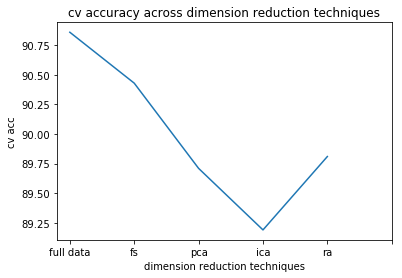

In [37]:
dim = np.array(["full data","fs","pca","ica","ra"])
cv_acc_1 = np.array([cv_acc_2_org,cv_acc_2_dt,cv_acc_2_pca,cv_acc_2_ica,cv_acc_2_ra])
plt.plot(cv_acc_1)
plt.xticks([0,1, 2, 3,4,5], dim)
plt.xlabel('dimension reduction techniques')
plt.ylabel('cv acc')
plt.title('cv accuracy across dimension reduction techniques')
plt.show()

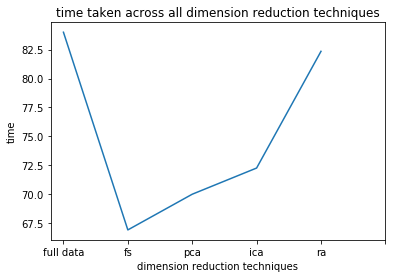

In [44]:
dim = np.array(["full data","fs","pca","ica","ra"])
cv_acc_1 = np.array([times_2_org,times_2_dt,times_2_pca,times_2_ica,times_2_ra])
plt.plot(cv_acc_1)
plt.xticks([0,1, 2, 3,4,5], dim)
plt.xlabel('dimension reduction techniques')
plt.ylabel('time')
plt.title('time taken across all dimension reduction techniques')
plt.show()

# Cluster Data + Neural Networks

first dataset

In [45]:
#data
km1 = KMeans(n_clusters=5, random_state=0).fit_predict(X_1)
gmm = GaussianMixture(12, covariance_type='full', random_state=0).fit(X_1)
gmm_1 = gmm.predict_proba(X_1)
cluster1=pd.DataFrame(gmm_1)
cluster1['km']=pd.DataFrame(km1)
cluster1.shape

(39644, 13)

In [46]:
#nn
c1_xtrain, c1_xtest, c1_ytrain, c1_ytest = split(cluster1, Y_1)
vary_grid_1_clus,times_1_clus,cv_acc_1_clus,train_acc_1_clus,test_acc_1_clus=vary_func1(c1_xtrain,c1_ytrain,c1_xtest,c1_ytest,c1_xtrain.shape[1],1,vary_1_param_1,3)

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=13, units=20, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=10, kernel_initializer="uniform")`
  import sys
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if __name__ == '__main__':


Epoch 1/10
18500/18500 [==============================] - 2s 129us/step - loss: 0.6787 - acc: 0.5973
Epoch 2/10
18500/18500 [==============================] - 1s 43us/step - loss: 0.6589 - acc: 0.6165
Epoch 3/10
18500/18500 [==============================] - 0s 27us/step - loss: 0.6569 - acc: 0.6209
Epoch 4/10
18500/18500 [==============================] - 1s 33us/step - loss: 0.6564 - acc: 0.6216
Epoch 5/10
18500/18500 [==============================] - 1s 34us/step - loss: 0.6562 - acc: 0.6209
Epoch 6/10
18500/18500 [==============================] - 1s 35us/step - loss: 0.6561 - acc: 0.6217
Epoch 7/10
18500/18500 [==============================] - 1s 36us/step - loss: 0.6561 - acc: 0.6210
Epoch 8/10
18500/18500 [==============================] - 1s 35us/step - loss: 0.6559 - acc: 0.6213
Epoch 9/10
18500/18500 [==============================] - 0s 25us/step - loss: 0.6560 - acc: 0.6215
Epoch 10/10
18500/18500 [==============================] - 0s 22us/step - loss: 0.6558 - acc: 0.620

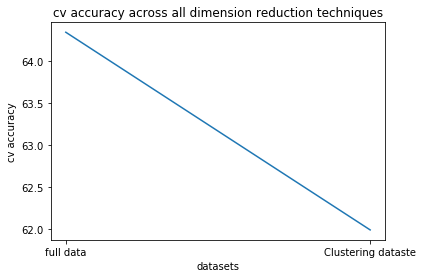

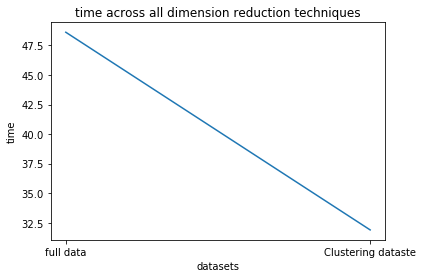

In [58]:
dim = np.array(["full data","Clustering dataste"])

cv_acc_1 = np.array([cv_acc_1_org,cv_acc_1_clus])
plt.plot(cv_acc_1)
plt.xticks([0,1], dim)
plt.xlabel('datasets')
plt.ylabel('cv accuracy')
plt.title('cv accuracy across all dimension reduction techniques')
plt.show()

cv_acc_1 = np.array([times_1_org,times_1_clus])
plt.plot(cv_acc_1)
plt.xticks([0,1], dim)
plt.xlabel('datasets')
plt.ylabel('time')
plt.title('time across all dimension reduction techniques')
plt.show()

second dataset

In [48]:
#data
km2 = KMeans(n_clusters=3, random_state=0).fit_predict(X_2)
gmm = GaussianMixture(8, covariance_type='full', random_state=0).fit(X_2)
gmm_2 = gmm.predict_proba(X_2)
cluster2=pd.DataFrame(gmm_2)
cluster2['km']=pd.DataFrame(km2)
cluster2.shape

(41188, 9)

In [49]:
#nn
c2_xtrain, c2_xtest, c2_ytrain, c2_ytest = split(cluster2, Y_2)
vary_grid_2_clus,times_2_clus,cv_acc_2_clus,train_acc_2_clus,test_acc_2_clus=vary_func1(c2_xtrain,c2_ytrain,c2_xtest,c2_ytest,c2_xtrain.shape[1],1,vary_1_param_2,3)

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=9, units=30, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=15, kernel_initializer="uniform")`
  import sys
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if __name__ == '__main__':


Epoch 1/10
19220/19220 [==============================] - 2s 96us/step - loss: 0.3722 - acc: 0.8866
Epoch 2/10
19220/19220 [==============================] - 1s 46us/step - loss: 0.3191 - acc: 0.8876
Epoch 3/10
19220/19220 [==============================] - 1s 58us/step - loss: 0.3168 - acc: 0.8876
Epoch 4/10
19220/19220 [==============================] - 1s 58us/step - loss: 0.3154 - acc: 0.8876
Epoch 5/10
19220/19220 [==============================] - 1s 42us/step - loss: 0.3146 - acc: 0.8876: 0s - loss: 0.3120 - a
Epoch 6/10
19220/19220 [==============================] - 1s 41us/step - loss: 0.3139 - acc: 0.8876
Epoch 7/10
19220/19220 [==============================] - 1s 40us/step - loss: 0.3137 - acc: 0.8876
Epoch 8/10
19220/19220 [==============================] - 1s 41us/step - loss: 0.3134 - acc: 0.8876
Epoch 9/10
19220/19220 [==============================] - 1s 39us/step - loss: 0.3134 - acc: 0.8876
Epoch 10/10
19220/19220 [==============================] - 1s 40us/step - los

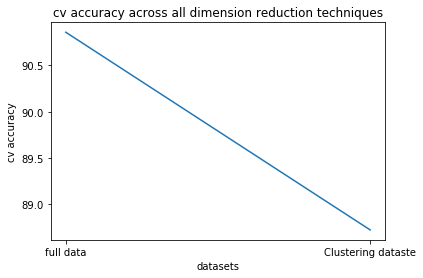

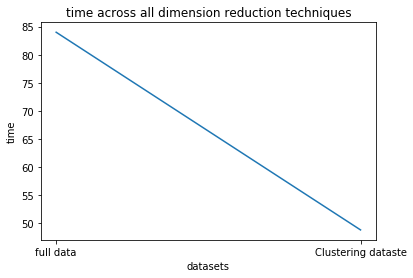

In [59]:
dim = np.array(["full data","Clustering dataste"])

cv_acc_1 = np.array([cv_acc_2_org,cv_acc_2_clus])
plt.plot(cv_acc_1)
plt.xticks([0,1], dim)
plt.xlabel('datasets')
plt.ylabel('cv accuracy')
plt.title('cv accuracy across all dimension reduction techniques')
plt.show()

cv_acc_1 = np.array([times_2_org,times_2_clus])
plt.plot(cv_acc_1)
plt.xticks([0,1], dim)
plt.xlabel('datasets')
plt.ylabel('time')
plt.title('time across all dimension reduction techniques')
plt.show()